# Homework 2, Step 1. MLP for CIFAR-100
In HW1, you have tried the MLP for the MNIST classification. In HW2, you will try a harder classification dataset: CIFAR-100.

In the step 1, you need to try MLP on the CIFAR-100 classification.

## 1. Prepare the dataset and the model
### Import Library

In [1]:
import os
import sys

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time

import tqdm

### Hyperparameters

In [2]:
lr = 0.05  # learning rate
batchsize = 256  # training batchsize

### Load Dataset
In pytorch, you can use the following API to load the dataset.

The RGB mean and std are pre-calculated values for normalizing the data. **Do not modify them**.

In [3]:
rgb_mean = np.array([0.4914, 0.4822, 0.4465])
rgb_std = np.array([0.2023, 0.1994, 0.2010])
transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(rgb_mean, rgb_std),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(rgb_mean, rgb_std),
    ]
)

trainset = torchvision.datasets.CIFAR100(
    root="../data", train=True, download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batchsize, shuffle=True, num_workers=1
)

testset = torchvision.datasets.CIFAR100(
    root="../data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=500, shuffle=False, num_workers=1
)

Files already downloaded and verified
Files already downloaded and verified


### Visualize the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

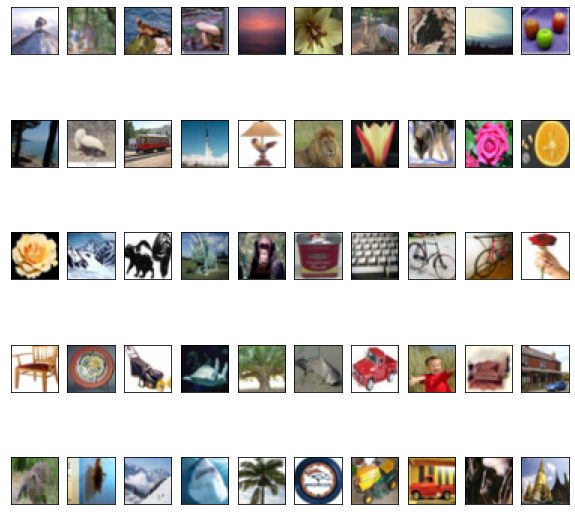

In [4]:
import matplotlib.pyplot as plt


def display_image(images):  # [bs, c, h, w]
    mean, std = torch.tensor(rgb_mean).view(1, 3, 1, 1), torch.tensor(rgb_std).view(
        1, 3, 1, 1
    )
    images = images * std + mean
    rows = 5
    columns = images.size(0) // rows
    images = np.array(images)
    images = images.transpose(0, 2, 3, 1)
    # define figure
    fig = plt.figure(figsize=(10, 10))
    # visualize these random images
    for i in range(1, columns * rows + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i - 1])
        plt.xticks([])
        plt.yticks([])
    plt.show()


for x, y in testloader:
    display_image(x[:50])
    break

### Define the MLP Model

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[]) -> None:
        super().__init__()

        idims, odims = [input_dim, *hidden_dims], [*hidden_dims, num_classes]
        layers = []
        for i in range(len(idims) - 1):
            idim, odim = idims[i], odims[i]
            layers.append(nn.Linear(idim, odim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(idims[-1], odims[-1]))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        out = self.layers(x)
        return out

## 2. Define the model and run

### Training settings
**TODO**: Modify the `num_epochs` and the `hidden_dims` for the better performance.

In [6]:
num_epochs = 20  # training epochs
hidden_dims = [512, 256]  # hidden dims for MLP
logging_steps = 100  # logging batchsize
best_acc = 0.0  # best accuracy

### Define the model, optimizer, loss function, learning rate scheduler

In [7]:
net = MLP(input_dim=32 * 32 * 3, num_classes=100, hidden_dims=hidden_dims)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
net = net.to(device)  # put the model on the specified device(e.g. gpu/cpu)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(net.parameters(), lr=lr)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

cpu


### Check the total number of parameters

In [8]:
def test(net):
    import numpy as np

    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.shape)
    print("Total number of parameters", total_params)
    print(
        "Total layers",
        len(
            list(
                filter(
                    lambda p: p.requires_grad and len(p.data.size()) > 1,
                    net.parameters(),
                )
            )
        ),
    )


test(net)

Total number of parameters 1730404
Total layers 3


### Training logs
The training logs are saved in the `exp_step1` folder. You can use tensorboard to see the logs.

In [9]:
if not os.path.exists("exp_step1"):
    os.mkdir("exp_step1")
last_train = max([eval(s.split("-")[-1]) for s in os.listdir("exp_step1")] + [0])
current_train = last_train + 1
save_dir = "exp_step1/cifar100-{}".format(current_train)
os.makedirs(save_dir)
writer = SummaryWriter(save_dir)

best_acc = 0

### Training and testing

In [10]:
# Training
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    with tqdm.tqdm(enumerate(trainloader), total=len(trainloader)) as t:
        t.set_description(f"Epoch {epoch} train")
        for batch_idx, (inputs, targets) in t:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

#             writer.add_scalars(
#                 "loss",
#                 {"train": loss.item()},
#                 global_step=epoch * len(trainloader) + batch_idx,
#             )

            t.set_postfix(
                {
                    "loss": f"{train_loss/(batch_idx+1):.3f}",
                    "acc": f"{100.*correct/total:.3f}%, {correct}/{total}",
                }
            )
        
    writer.add_scalars(
        "loss", {"train": train_loss/len(trainloader)},
        global_step=epoch * len(trainloader)
    )
    writer.add_scalars(
        "accuracy", {"train": correct/total},
        global_step=epoch * len(trainloader)
    )


# validation
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        with tqdm.tqdm(enumerate(testloader), total=len(testloader)) as t:
            t.set_description(f"Epoch {epoch}  test")
            for batch_idx, (inputs, targets) in t:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                t.set_postfix(
                    {
                        "loss": f"{test_loss / (batch_idx + 1):.3f}",
                        "acc": f"{correct*100./total:.3f}%, {correct}/{total}",
                    }
                )

    writer.add_scalars(
        "loss", {"test": test_loss/len(testloader)},
        global_step=epoch * len(trainloader)
    )
    writer.add_scalars(
        "accuracy", {"test": correct/total},
        global_step=epoch * len(trainloader)
    )
    
    # Save checkpoint.
    acc = 100.0 * correct / total
    if acc > best_acc:
        print("Saving..")
        state = {
            "net": net.state_dict(),
            "acc": acc,
            "epoch": epoch,
        }
        torch.save(state, os.path.join(save_dir, "ckpt.pth"))
        best_acc = acc

    return acc


for epoch in range(0, num_epochs):
    tic = time.time()
    train(epoch)
    test_acc = test(epoch)
    t = time.time() - tic
    print(
        f"Epoch {epoch} | total time: {t:.0f}s, test acc: {test_acc:.3f}%, best acc: {best_acc:.3f}%"
    )

    scheduler.step()

Epoch 0  test: 100%|██████████| 20/20 [00:03<00:00,  6.24it/s, loss=3.863, acc=11.090%, 1109/10000]

Saving..
Epoch 0 | total time: 17s, test acc: 11.090%, best acc: 11.090%



Epoch 1  test: 100%|██████████| 20/20 [00:03<00:00,  6.24it/s, loss=3.638, acc=16.040%, 1604/10000]

Saving..
Epoch 1 | total time: 17s, test acc: 16.040%, best acc: 16.040%



Epoch 2  test: 100%|██████████| 20/20 [00:02<00:00,  7.30it/s, loss=3.563, acc=16.600%, 1660/10000]

Saving..
Epoch 2 | total time: 17s, test acc: 16.600%, best acc: 16.600%



Epoch 3  test: 100%|██████████| 20/20 [00:03<00:00,  6.31it/s, loss=3.469, acc=18.130%, 1813/10000]

Saving..
Epoch 3 | total time: 17s, test acc: 18.130%, best acc: 18.130%



Epoch 4  test: 100%|██████████| 20/20 [00:03<00:00,  6.32it/s, loss=3.398, acc=19.580%, 1958/10000]

Saving..
Epoch 4 | total time: 18s, test acc: 19.580%, best acc: 19.580%



Epoch 5  test: 100%|██████████| 20/20 [00:02<00:00,  6.67it/s, loss=3.355, acc=20.370%, 2037/10000]

Saving..
Epoch 5 | total time: 17s, test acc: 20.370%, best acc: 20.370%



Epoch 6  test: 100%|██████████| 20/20 [00:03<00:00,  5.84it/s, loss=3.331, acc=21.300%, 2130/10000]

Saving..
Epoch 6 | total time: 17s, test acc: 21.300%, best acc: 21.300%



Epoch 7  test: 100%|██████████| 20/20 [00:03<00:00,  6.24it/s, loss=3.277, acc=22.120%, 2212/10000]

Saving..
Epoch 7 | total time: 17s, test acc: 22.120%, best acc: 22.120%



Epoch 8  test: 100%|██████████| 20/20 [00:03<00:00,  6.25it/s, loss=3.270, acc=22.450%, 2245/10000]

Saving..
Epoch 8 | total time: 17s, test acc: 22.450%, best acc: 22.450%



Epoch 9  test: 100%|██████████| 20/20 [00:03<00:00,  6.27it/s, loss=3.278, acc=22.520%, 2252/10000]

Saving..
Epoch 9 | total time: 18s, test acc: 22.520%, best acc: 22.520%



Epoch 10  test: 100%|██████████| 20/20 [00:03<00:00,  6.24it/s, loss=3.233, acc=23.530%, 2353/10000]

Saving..
Epoch 10 | total time: 17s, test acc: 23.530%, best acc: 23.530%



Epoch 11  test: 100%|██████████| 20/20 [00:02<00:00,  6.91it/s, loss=3.300, acc=22.800%, 2280/10000]

Epoch 11 | total time: 17s, test acc: 22.800%, best acc: 23.530%



Epoch 12  test: 100%|██████████| 20/20 [00:03<00:00,  6.29it/s, loss=3.194, acc=24.620%, 2462/10000]

Saving..
Epoch 12 | total time: 17s, test acc: 24.620%, best acc: 24.620%



Epoch 13  test: 100%|██████████| 20/20 [00:03<00:00,  6.31it/s, loss=3.289, acc=23.310%, 2331/10000]

Epoch 13 | total time: 18s, test acc: 23.310%, best acc: 24.620%



Epoch 14  test: 100%|██████████| 20/20 [00:03<00:00,  6.32it/s, loss=3.313, acc=23.640%, 2364/10000]

Epoch 14 | total time: 17s, test acc: 23.640%, best acc: 24.620%



Epoch 15  test: 100%|██████████| 20/20 [00:02<00:00,  7.17it/s, loss=3.320, acc=24.220%, 2422/10000]

Epoch 15 | total time: 17s, test acc: 24.220%, best acc: 24.620%



Epoch 16  test: 100%|██████████| 20/20 [00:03<00:00,  6.33it/s, loss=3.423, acc=21.740%, 2174/10000]

Epoch 16 | total time: 18s, test acc: 21.740%, best acc: 24.620%



Epoch 17  test: 100%|██████████| 20/20 [00:03<00:00,  6.34it/s, loss=3.417, acc=22.980%, 2298/10000]

Epoch 17 | total time: 17s, test acc: 22.980%, best acc: 24.620%



Epoch 18  test: 100%|██████████| 20/20 [00:03<00:00,  6.60it/s, loss=3.439, acc=22.690%, 2269/10000]

Epoch 18 | total time: 17s, test acc: 22.690%, best acc: 24.620%



Epoch 19  test: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s, loss=3.519, acc=22.710%, 2271/10000]

Epoch 19 | total time: 17s, test acc: 22.710%, best acc: 24.620%
